## Linear Regression and RANSAC

In [1]:
# Load the modules we need
import numpy as np
from matplotlib import pyplot as plt
from sklearn import linear_model, datasets
import random
from scipy import stats
import math

In [2]:
#  Create some intial data
n_samples = 1000

X, y = datasets.make_regression(n_samples=n_samples, n_features=1,
                                      n_informative=1, noise=10,
                                      random_state=0)

In [3]:
# Add some outlier data
np.random.seed(0)
n_outliers = 50
X[:n_outliers] = 3 + 0.5 * np.random.normal(size=(n_outliers, 1))
y[:n_outliers] = -3 + 10 * np.random.normal(size=n_outliers)

In [4]:
# Create some test positions for for the lines we will draw
line_X = np.arange(X.min(), X.max())[:, np.newaxis]
print(line_X)

[[-3.04614305]
 [-2.04614305]
 [-1.04614305]
 [-0.04614305]
 [ 0.95385695]
 [ 1.95385695]
 [ 2.95385695]
 [ 3.95385695]]


In [5]:
def LinearRegression(X, y):
    alpha = calAlpha(X, y)
    beta = calBeta(X)
    gamma = calGamma(X)
    delta = calDelta(y)
    mandc = calMandC(alpha, beta, gamma, delta)
    return mandc

In [6]:
def predict(line_X, mandc):
    line_y = np.zeros((len(line_X)))
    for i in range(len(line_X)):
        line_y[i] = mandc[0] * line_X[i] + mandc[1]
    return line_y

In [7]:
def calAlpha(X, y):
    total = 0
    for i in range(len(X)):
        temp = X[i] * y[i]
        total += temp
    return total    

In [8]:
def calBeta(X):
    total = 0
    for i in range(len(X)):
        temp = X[i] * X[i]
        total += temp
    return total    

In [9]:
def calGamma(X):
    total = 0
    for i in range(len(X)):
        total += X[i]
    return total  

In [10]:
def calDelta(y):
    total = 0
    for i in range(len(y)):
        total += y[i]
    return total  

In [11]:
def calMandC(alpha, beta, gamma, delta):
    N = len(X)
    A = np.array([[beta, gamma],[gamma, N]], dtype='float')
    A_inv = np.linalg.inv(A)
    B = np.array([[alpha],[delta]], dtype='float')
    Ans = A_inv.dot(B)
    return Ans

In [12]:
lr = LinearRegression(X, y)
line_y = predict(line_X, lr)
print(line_y)

[-174.38323639 -120.21087252  -66.03850865  -11.86614478   42.30621909
   96.47858295  150.65094682  204.82331069]


In [13]:
def generate2RandomX(X, y):
    coord1 = []
    coord2 = []
    i = random.randrange(len(X))
    coord1.append(X[i])
    coord1.append(y[i])
    j = random.randrange(len(X))
    coord2.append(X[j])
    coord2.append(y[j])
    return coord1, coord2

In [14]:
def findLineEquation(coord1, coord2):
    m = (coord2[1] - coord1[1])/(coord2[0] - coord1[0])
    c = coord2[1] - coord2[0] * m
    return m, c

In [15]:
def isInlier(y, yPred, madev):
    distance = abs(yPred - y)
    if distance < madev:
        return True
    return False

In [16]:
def findInliers(X, y, m, c):
    inliersX = []
    inliersY = []
    threshold = stats.median_absolute_deviation(y)
    for i in range(len(X)):
        yPred= m * X[i] + c
        if isInlier(y[i], yPred, threshold):
            inliersX.append(X[i])
            inliersY.append(y[i])
    return inliersX, inliersY

In [17]:
def findInliersMask(X, y, m, c):
    inliersMask = np.full((len(X)), False,dtype=bool)
    threshold = stats.median_absolute_deviation(y)
    for i in range(len(X)):
        yPred= m * X[i] + c
        if isInlier(y[i], yPred, threshold):
            inliersMask[i] = True
    return inliersMask

In [18]:
def RANSACRegressor():
    i = 0
    e = n_outliers / n_samples
    N = (math.log(1 - 0.99))/(math.log(1 - math.pow((1 - e), 2)))
    bestInlierAmount = -1
    bestInliersX = []
    bestInliersY = []
    while i < N:
        coord1, coord2 = generate2RandomX(X, y)
        m, c = findLineEquation(coord1, coord2)
        inliersX, inliersY = findInliers(X, y, m, c)
        if bestInlierAmount < 0:
            bestInlierAmount = len(inliersX)
            bestInliersX = inliersX
            bestInliersY = inliersY
        if bestInlierAmount < len(inliersX):
            bestInlierAmount = len(inliersX)
            bestInliersX = inliersX
            bestInliersY = inliersY
        i += 1
    return LinearRegression(bestInliersX, bestInliersY)

In [19]:
ransac = RANSACRegressor()
line_y_ransac = predict(line_X, ransac)
inlier_mask = findInliersMask(X, y, ransac[0], ransac[1])
print(line_y_ransac)

outlier_mask = np.logical_not(inlier_mask)

[-249.82117062 -167.73633982  -85.65150902   -3.56667821   78.51815259
  160.6029834   242.6878142   324.77264501]


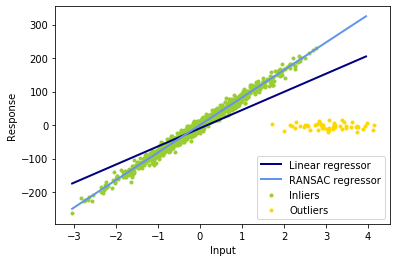

In [20]:
lw = 2

doing_linear = True
doing_ransac = True

if (doing_linear):
    plt.plot(line_X, line_y, color='navy', linewidth=lw, label='Linear regressor')

if (doing_ransac):
    plt.scatter(X[inlier_mask], y[inlier_mask], color='yellowgreen', marker='.', label='Inliers')
    plt.scatter(X[outlier_mask], y[outlier_mask], color='gold', marker='.', label='Outliers')
    plt.plot(line_X, line_y_ransac, color='cornflowerblue', linewidth=lw, label='RANSAC regressor')
else:
    plt.scatter(X, y, color='yellowgreen', marker='.', label='Data')
    
plt.legend(loc='lower right')
plt.xlabel("Input")
plt.ylabel("Response")
plt.show()